In [166]:
import pandas as pd
import os 
import subprocess
from src.files import BLASTJsonFile
from src.tools import MMseqs
from utils import * 
import glob
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
import dataframe_image as dfi
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
import subprocess
from scipy.stats import pearsonr
import imgkit

%load_ext autoreload 
%autoreload 2

# TODO: Why would balancing batches with up-sampling do so much better than weighted loss?
# TODO: Remind myself about difference between Pearson's R and Spearman's Rho, and the assumptions made for each. 
# TODO: Was the model successful at flagging unlabeled pseudogenes with InterProScan hits (the ones I didn't bother manually-labeling) as real?
# TODO: Look into why ORF prediction is worse in high-GC genomes. https://pubmed.ncbi.nlm.nih.gov/23000023/
# TODO: Is it possible to have ORFs in repeat regions?
# TODO: What exactly is UniParc, and how is it different from UniProtKB?
# TODO: What are the lengths of the hypothetical sequences flagged by the model, as compared to the annotated ones? I wonder if these
#   are just propogated errors, as they're likely all ab initio predictions (although the fact that they appear multiple times across different
#   species strengthens their likelihood of being real, the fact that AntiFam exists means this is not always true.)
# TODO: Are there differences in model confidence for spurious matches which could be annotated with InterProScan versus not?
# TODO: Is there any correlation between the number of BLAST hits and model confidence?
# TODO: Find out if any of the matches are suppressed.

is_pseudo = lambda df : df.top_hit_pseudo 
is_hypothetical = lambda df : df.top_hit_product.str.contains('hypothetical')

is_spurious = lambda df : df.label == 'spurious'
is_intergenic = lambda df : ~is_spurious(df) & (df.category == 'intergenic')
is_match = lambda df : ~is_spurious(df) & (df.category == 'match')
is_conflict = lambda df : ~is_spurious(df) & (df.category == 'conflict')
is_none = lambda df : ~is_spurious(df) & (df.category == 'none') # These are the suspect sequences, i.e. hypothetical and ab initio.  

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [112]:
# Based on the table_1 results, it seems as though the v2 model (two layers) made the fewest predictions... that means I think it might be the safest.
model_name = 'campylobacterota_esm_650m_gap_v2'

genome_ids = pd.read_csv('../data/campylobacterota_dataset.csv', index_col=0).genome_id.unique()
results = Results(genome_ids, load_ref=True, load_labels=True)
results.load_predict('../data/predict/campylobacterota_dataset_predict.csv', model_name=model_name)

genome_metadata_df = pd.read_csv('../data/genome_metadata.csv', index_col=0)

In [113]:
# In order to search against all of BLAST, need to break this up into separate files. Otherwise the BLAST query exceeds CPU limit.
# I ended up needing to limit the conflict search to Campylobacterota only anyway... 
for category in ['conflict', 'intergenic', 'none', 'match']: 
    results.to_fasta(f'../data/results/campylobacterota/v201/spurious_{category}.faa', model_label=0, category=category)
results.to_fasta(f'../data/results/campylobacterota/v201/spurious.faa', model_label=0)
# ~/interproscan/interproscan-5.73-104.0/interproscan.sh -i campylobacterota_spurious.faa -o campylobacterota_spurious_iterpro.tsv -f tsv

results.load_interpro(f'../data/results/campylobacterota/v201/spurious_interpro.tsv')
for category in ['conflict', 'intergenic', 'none', 'match']: 
    results.load_blast(f'../data/results/campylobacterota/v201/spurious_{category}_blast.json')

In [ ]:
def table_1(path:str='../data/figures/results-campylobacterota-v201-table_1.png'):
    results = Results(genome_ids=genome_ids, load_labels=True, load_ref=True)
    results.load_predict('../data/predict/campylobacterota_dataset_predict.csv', model_name=None)
    df = results.to_df()
    
    table_df = []
    model_names = ['campylobacterota_esm_650m_gap_v1', 'campylobacterota_esm_650m_gap_v2', 'campylobacterota_esm_650m_gap_v3']
    for model_name in model_names:
        df_ = df.groupby('category')[f'{model_name}_label'].value_counts().reset_index()
        df_ = df_.pivot(columns=f'{model_name}_label', values='count', index='category')
        df_.columns = pd.MultiIndex.from_tuples([(model_name, 'spurious'), (model_name, 'real')])
        table_df.append(df_)
    table_df = pd.concat(table_df, axis=1)

    dfi.export(table_df, path, table_conversion='matplotlib')
    return table_df 

table_1() 


campylobacterota_esm_650m_gap_v1          \
                                   spurious    real   
category                                              
conflict                                408     257   
intergenic                              167    3922   
match                                    73  361909   
none                                    229   42304   

           campylobacterota_esm_650m_gap_v2          \
                                   spurious    real   
category                                              
conflict                                383     282   
intergenic                              101    3988   
match                                    35  361947   
none                                    147   42386   

           campylobacterota_esm_650m_gap_v3          
                                   spurious    real  
category                                             
conflict                                400     265  
intergenic                              141    3948  
match                                    60  361922  
none                                    198   42335

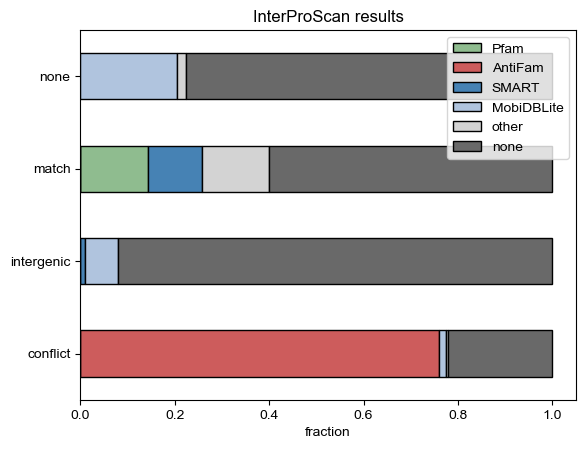

In [ ]:
def figure_1(results, normalize:bool=True, path:str='../data/figures/results-campylobacterota-v201-figure_1.png'):

    fig = plt.figure()
    ax = fig.add_subplot()

    df = results.to_df(model_label=0)

    ax_df = df[['model_label', 'category', 'label', 'interpro_analysis']].copy()
    ax_df['interpro_analysis'] = ax_df.interpro_analysis.replace({'Gene3D':'other', 'SUPERFAMILY':'other', 'PANTHER':'other', 'Coils':'other', 'ProSiteProfiles':'other'})
    ax_df = ax_df.groupby('category').interpro_analysis.value_counts().reset_index()
    ax_df = ax_df.pivot(index='category', columns='interpro_analysis', values='count').fillna(0)
    analysis_order = ['Pfam', 'AntiFam', 'SMART', 'MobiDBLite', 'other', 'none']
    analysis_order = [analysis for analysis in analysis_order if (analysis in ax_df.columns)] 
    ax_df = ax_df.loc[:, analysis_order]

    if normalize:
        ax_df = ax_df / ax_df.values.sum(axis=1).reshape(-1, 1)
    colors = {'none':'dimgray', 'Pfam':'darkseagreen', 'AntiFam':'indianred', 'MobiDBLite':'lightsteelblue', 'SMART':'steelblue', 'other':'lightgray'}
    ax_df.plot(kind='barh', stacked=True, ax=ax, edgecolor='black', color=colors) # color=['indianred', 'darkseagreen', 'lightsteelblue', 'steelblue', 'dimgray', 'lightgray'])
    ax.set_ylabel('')
    ax.set_xlabel('count' if (not normalize) else 'fraction')
    ax.set_title('InterProScan results')
    ax.legend().set_title('')

    fig.savefig(path, format='png', dpi=500)
    plt.show()

figure_1(results)

In [ ]:
# The things I am most worried are false positives are the "matches" which are predicted to be spurious, so I am going to take a closer look at those. 

# Sort the conflicts into categories: pseudogenes, hypothetical, hypothetical and pseudogenes, annotated. 
def figure_2(results, path:str='../data/figures/results-campylobacterota-v201-figure_2.png'):
    df = results.to_df(category='match', model_label=0) 

    fig = plt.figure()
    ax = fig.add_subplot()

    masks = [is_hypothetical(df) & ~is_pseudo(df), ~is_hypothetical(df) & is_pseudo(df), is_hypothetical(df) & is_pseudo(df), ~is_hypothetical(df) & ~is_pseudo(df)]
    categories = ['hypothetical', 'pseudogene', 'hypothetical pseudogene', 'annotated'] 

    ax_df = dict()
    ax_df['category'] = ['hypothetical', 'pseudogene', 'hypothetical pseudogene', 'annotated']
    ax_df['count'] = [mask.sum() for mask in masks]
    ax_df = pd.DataFrame(ax_df).sort_values('count')

    colors = {'hypothetical':'lightgray', 'pseudogene':'steelblue', 'hypothetical pseudogene':'lightsteelblue', 'annotated':'darkseagreen'}
    ax.pie(ax_df['count'], labels=ax_df.category, colors=[colors[category] for category in ax_df.category], autopct='%.1f%%', wedgeprops={'linewidth':0.7, 'edgecolor':'black'})
    
    fig.savefig(path, format='png', dpi=500)
    plt.show()


def table_2(results, path:str='../data/figures/results-campylobacterota-v201-table_2.png'):
    df = results.to_df(category='match', model_label=0, top_hit_pseudo=False)
    df = df[~is_hypothetical(df)]

    table_df = df[['model_output_0', 'top_hit_product', 'interpro_analysis', 'interpro_e_value']].copy()
    table_df['interpro_hit'] = [row.interpro_description if (row.interpro_description != 'none') else row.interpro_signature_description for row in df.itertuples()]
    table_df = table_df.sort_values('model_output_0')
    table_df['interpro_e_value'] = table_df.interpro_e_value.apply(lambda e : f'{e:.2e}')
    table_df['model_output_0'] = table_df.model_output_0.apply(lambda n : f'{n:.2f}')
    table_df['interpro_hit'] = table_df.interpro_hit.apply(lambda s : s[0].lower() + s[1:])
    table_df = table_df.rename(columns={'model_output_0':'model output', 'top_hit_product':'product', 'interpro_e_value':'E-value', 'interpro_hit':'InterProScan hit'})

    table_df = table_df.style.set_properties(**{'text-align':'left', 'white-space':'pre-wrap'})

    table_df.export_png(path, table_conversion='matplotlib')
    # # Need to install a package for this: apt-get install wkhtmltopdf
    # imgkit.from_string(table_df.to_html(), path)

    return table_df

# For the flagged pseudogenes, there doesn't seem to be any relationship between the model output and (1) whether or not the pseudogene
# is in-frame with the Prodigal prediction, (2) the length difference between the pseudogene and Prodigal prediction, or (3) the top hit
# overlap fraction. 

table_2(results)


,model output,product,interpro_analysis,E-value,InterProScan hit
id,,,,,
NZ_VWSJ01000005.1_28,0.54,replication endonuclease,Pfam,3.90e-06,replication gene A protein-like
NZ_JBHRZO010000001.1_48,0.59,membrane protein insertion efficiency factor YidD,Pfam,3.60e-11,membrane protein insertion efficiency factor YidD-like
NZ_BBQE01000004.1_19,0.75,phage tail protein,SUPERFAMILY,9.16e-21,receptor-binding domain of short tail fibre protein gp12
NZ_CP012541.1_1487,0.80,DUF2625 family protein,Pfam,1.10e-19,protein of unknown function DUF2625
NZ_QXQT01000015.1_14,0.81,membrane protein insertion efficiency factor YidD,Pfam,8.20e-12,membrane protein insertion efficiency factor YidD-like
NZ_CP011308.1_2171,0.84,replication endonuclease,Pfam,2.50e-15,replication gene A protein-like
NZ_CDMK01000003.1_60,0.85,membrane protein insertion efficiency factor YidD,SMART,1.70e-28,membrane protein insertion efficiency factor YidD-like
NC_014810.2_1194,0.86,membrane protein insertion efficiency factor YidD,SMART,1.40e-20,membrane protein insertion efficiency factor YidD-like
NZ_ATUV01000002.1_190,0.93,membrane protein insertion efficiency factor YidD,SMART,3.10e-42,membrane protein insertion efficiency factor YidD-like


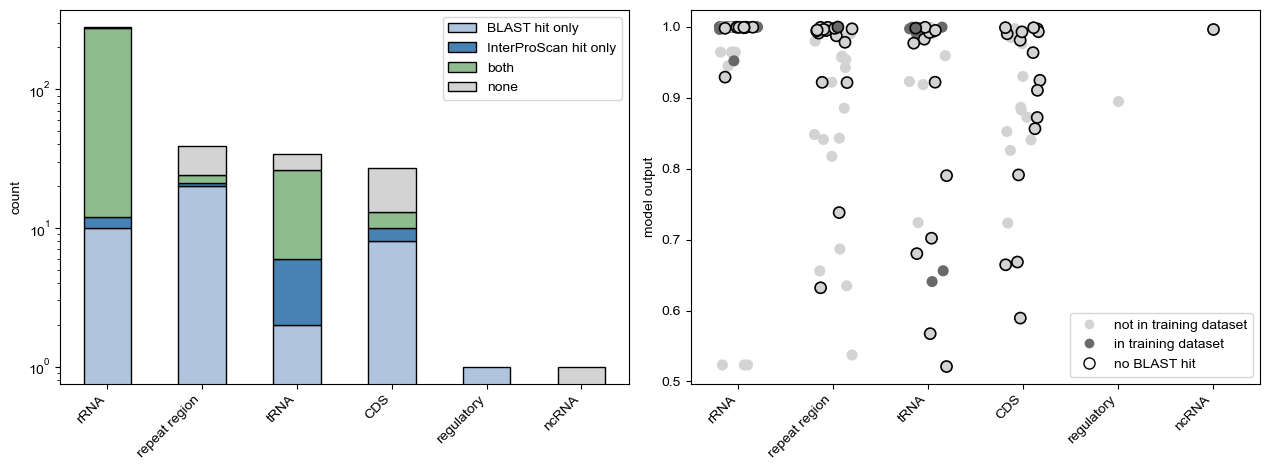

In [ ]:
# The category which I am most likely to use to augment the negative data are the conflicts which are flagged as spurious. 
# I should take a closer look at those, particularly those which are unannotated. 
# All sequences with AntiFam hits were included in the training data as negative cases. 

has_interpro_hit = lambda df : (df.interpro_analysis != 'none')
has_blast_hit = lambda df : (df.blast_subject_id != 'none')

def figure_5(results, path:str='../data/figures/results-campylobacterota-v201-figure_f.png'):

    fig = plt.figure(layout='tight', figsize=(6.4 * 2, 4.8))
    grid = GridSpec(nrows=1, ncols=2, figure=fig)
    ax_a = fig.add_subplot(grid[0, 0])
    ax_b = fig.add_subplot(grid[0, 1])

    df = results.to_df(category='conflict', model_label=0)
    train_ids = pd.read_csv('../data/campylobacterota_dataset_train.csv', index_col=0, usecols=['id']).index
    df['in_train_dataset'] = df.index.isin(train_ids)

    ax_a_df = df[['top_hit_feature']].copy()
    # assert ((df.interpro_analysis == 'AntiFam') & (df.blast_subject_id == 'none')).sum() == 0, 'figure_5: There are some cases where there is an InterProScan hit and no BLAST hit'
    masks = [has_interpro_hit(df) & ~has_blast_hit(df), ~has_interpro_hit(df) & has_blast_hit(df), has_interpro_hit(df) & has_blast_hit(df)]
    ax_a_df['hit'] = np.select(masks, ['InterProScan hit only', 'BLAST hit only', 'both'], default='none')
    ax_a_df = ax_a_df.value_counts().reset_index()
    ax_a_df = ax_a_df.pivot(columns='hit', index='top_hit_feature', values='count').fillna(0)
    ax_a_df = ax_a_df.loc[['rRNA', 'repeat_region', 'tRNA', 'CDS', 'regulatory', 'ncRNA'], :]
    colors = {'InterProScan hit only':'steelblue', 'BLAST hit only':'lightsteelblue', 'both':'darkseagreen', 'none':'lightgray'}
    ax_a_df.plot(kind='bar', ax=ax_a, stacked=True, edgecolor='black', color=colors)
    ax_a.set_xlabel('')
    ax_a.set_ylabel('count')
    ax_a.set_yscale('log')
    ax_a.legend().set_title('')
    ax_a.set_xticks(np.arange(len(ax_a_df)), labels=[feature.replace('_', ' ') for feature in ax_a_df.index], rotation=45, ha='right')
    
    ax_b_df = df[['top_hit_feature', 'model_output_0', 'in_train_dataset']].copy()
    ax_b_df['blast_hit'] = has_blast_hit(df)
    # ax_b_df['antifam_hit'] = df.interpro_analysis == 'AntiFam'
    sns.stripplot(data=ax_b_df[ax_b_df.blast_hit], x='top_hit_feature', y='model_output_0', ax=ax_b, hue='in_train_dataset', palette=['lightgray', 'dimgray'], s=8, jitter=0.2, order=ax_a_df.index) #, linecolor='black', fill=True, linewidth=1) #, flierprops=flierprops)
    sns.stripplot(data=ax_b_df[~ax_b_df.blast_hit], x='top_hit_feature', y='model_output_0', ax=ax_b, hue='in_train_dataset', palette=['lightgray', 'dimgray'], s=8, linewidth=1.2, edgecolor='black', jitter=0.2, order=ax_a_df.index) #, linecolor='black', fill=True, linewidth=1) #, flierprops=flierprops)
    ax_b.set_xlabel('')
    ax_b.set_ylabel('model output')
    ax_b.set_xticks(np.arange(ax_b_df.top_hit_feature.nunique()), labels=[feature.replace('_', ' ') for feature in ax_a_df.index], rotation=45, ha='right')
    
    handles = list()
    handles += [Line2D([0], [0], marker='o', ls='none', markerfacecolor='lightgray', markeredgecolor='white', label='not in training dataset', markersize=8)]
    handles += [Line2D([0], [0], marker='o', ls='none', markerfacecolor='dimgray', markeredgecolor='white', label='in training dataset', markersize=8)]
    handles += [Line2D([0], [0], marker='o', ls='none', markerfacecolor='none', markeredgecolor='black', linewidth=1.2, label='no BLAST hit', markersize=8)]
    ax_b.legend(handles=handles)

    fig.savefig(path, format='png', dpi=500)
    plt.show()

figure_5(results)



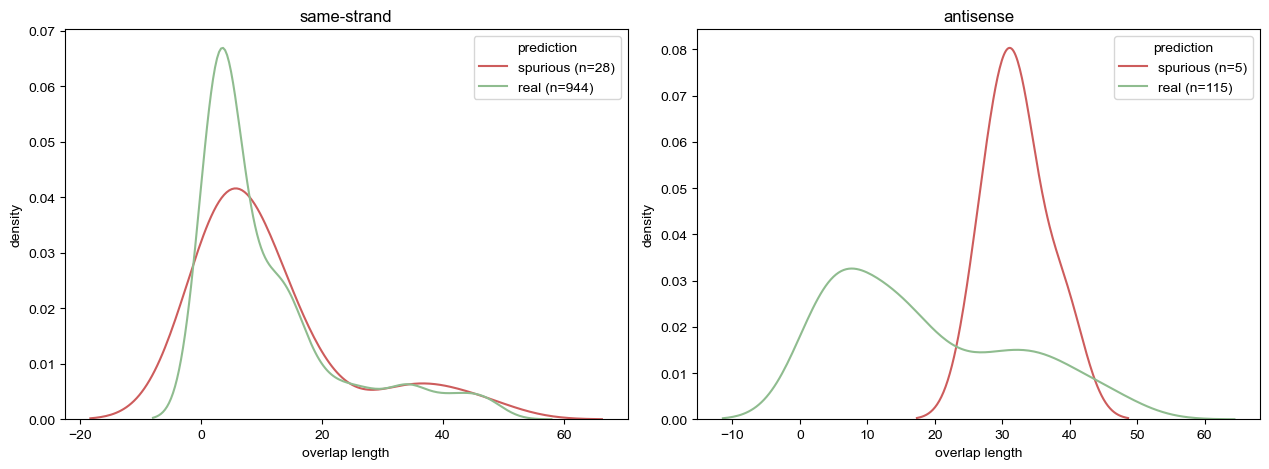

In [ ]:
# I bet pretty much all the intergenic predictions with no BLAST hit are spurious, so want to convey that in the figure. 

def figure_6(results, path:str=None):

    df = results.to_df(category='intergenic') # , model_label=0)

    fig = plt.figure(layout='tight', figsize=(6.4 * 2, 4.8))
    grid = GridSpec(ncols=2, nrows=1, figure=fig)
    axes = [fig.add_subplot(grid[0, i]) for i in range(2)]
    
    categories = ['same-strand', 'antisense', 'none']
    masks = [(df.overlap_length > 0) & (df.same_strand), (df.overlap_length > 0) & (~df.same_strand), df.overlap_length == 0] 
    ax_df = df[['overlap_length', 'model_label']].copy()
    ax_df['category'] = np.select(masks, categories, default=None)

    for category, ax in zip(categories[:-1], axes):
        ax_df_ = ax_df[ax_df.category == category]
        n_real = int(ax_df_.model_label.sum())
        n_spurious = len(ax_df_) - n_real

        ax = sns.kdeplot(ax=ax, data=ax_df_[ax_df_.model_label == 0], x='overlap_length', common_norm=False, label=f'spurious (n={n_spurious})', color='indianred')
        ax = sns.kdeplot(ax=ax, data=ax_df_[ax_df_.model_label == 1], x='overlap_length', common_norm=False, label=f'real (n={n_real})', color='darkseagreen')
        ax.legend()
        ax.legend().set_title('prediction')

        ax.set_title(category)
        ax.set_ylabel('density')
        ax.set_xlabel('overlap length')

    plt.show()


figure_6(results)


In [155]:

df = results.to_df(category='conflict', model_label=0)  
cols = ['blast_subject_id', 'genome_id', 'model_output_0', 'overlap_length', 'same_strand', 'top_hit_product', 'top_hit_feature', 'blast_subject_description', 'blast_e_value', 'interpro_analysis', 'interpro_signature_description']
df = df.sort_index()

df[['top_hit_evidence_details']].to_csv('~/Downloads/x.csv')

cols = ['n_hits', 'pseudo', 'blast_n_hits', 'blast_n_subject_taxa', 'same_strand', 'blast_subject_id', 'blast_query_length', 'blast_alignment_length', 'blast_subject_length', 'blast_positive', 'top_hit_evidence_type', 'top_hit_evidence_details']
entry = df.loc['NZ_AP023212.1_984']
print(entry.query_seq)
print(entry.top_hit_seq)
print(entry.blast_alignment)

# NZ_CP011308.1_2171 (exact match)
# NZ_VWSJ01000005.1_28 (N-terminal extended)

# NZ_JBHRZO010000001.1_48 (exact match)
# NC_014810.2_1194 (exact match)

# NZ_MUXF01000016.1_135 (exact match)
# NC_009850.1_1983 (N-terminal extended, but only by 2 aa)

# entry = df.loc['NZ_MUXF01000016.1_135']
# print(entry.reason)
# print(entry.query_seq)
# print(entry.top_hit_seq)
# print()
# entry = df.loc['NC_009850.1_1983']
# print(entry.reason)
# print(entry.query_seq)
# print(entry.top_hit_seq)

# Should add another disclaimer about the fact that this approach does not necessarily solve the error propogation problem, because apparently 
# conserved hypothetical proteins are included in the training data as "real." Relying on the fact that more of these conserved hypothetical groups are real than 
# simply propogated errors. 


MSWLYSRALAEAYLAAKSSIGERSVRSRSTSMPDMYSSHVRTTERSTRSRYGMTCERLTEDRGEALLTWFREASRARTSPSPEKEKDLKESEAGSGRKWRELSVKYDPDTSSWKTHRCLFPGDSIECLPTLPRFGLMRYGELWERTTPALHTVERDCGYWPTPTVCGNYNRPKDGTNSGTGLATAVGGRLNPEWVEWLMAWPIGHTDLKPLETDRFREWWRWHGEF
MALFAGAGGGILGGKILDWRTVCAVEIDEYARHVLVARQNDGTFDPFPIWDDVRTFDGRPWRGIVDVVSGGFPCQDISIAGKGKGLEGERSGLWSEMARIIGEVRPRYVFVENSPMLVSRGLDRVLADLAALRLNAVWGVVGADDAGASHRRKRLWILAYADGMRELQQTERRDEQRDWVGDCRRWPPEPGVGRVVDGLAHRTHRLKALGNGQVPRVVAMAWRILMREAMG
D  E  AGSGR+WRELS ++D DTSSWKT +CLF   SI  L TLP++G+ R GELWE T P    VER  GYWPTPT+ GN N PK+GT  G GLATAV


In [ ]:
df = results.to_df()
df[df.top_hit_evidence_details == 'NZ_AP023212.1_984'][['model_output_0', 'genome_id']]
# f[df.index == 'NZ_VWSJ01000005.1_28'][['top_hit_evidence_details']]

# NZ_CP011308.1_2170
# NZ_CP011308.1_2171

print(df.loc['NZ_CP011308.1_2171'].reason)
print(df.loc['NZ_CP011308.1_2171'].query_seq)
print(df.loc['NZ_CP011308.1_2170'].reason)
print(df.loc['NZ_CP011308.1_2170'].query_seq)
df[df.top_hit_evidence_details == 'WP_014475222.1'][['model_output_0', 'genome_id', 'category', 'blast_query_length']]

# Why do some sequences which should be similar end up with such wildly different values for model confidence?

alignment score 1.0 with WP_169745678.1
MECLGYLIQSCGHIILLENIYTKPLIFIGFFVKLYLTIYQELIVKTKNLQYGLTRRGVRMAKAKISRAKLFLNSHYLVSKAGDKIPLIDCYKSPTINADRYVAEIQHRVYSMVEYAQDRGLETIFLTLTLPSAYHKMKTINGKLVYNPKYADGTDNYDDYTPKAGSKYLTKMLAKIRQDRSYKEIDPDDRCSFRVMEPHKNGTPHVHVAMFVPRYAVARLIDAIFRLFPFPQSDISSTYIPDEWQESFVWEKGKKKQVFKKNDGTKNFIRVQVQDSYSYMLKYIYKTLDDLRGDGKISELSYWYISNGITRFYTSRTLVSLSIYRPLNGRFTMLELTKLYRDKQLQVFLNESTKKPELMILGSDIIYDRQKYVLEEKEMSYDEVQKVSTVDDDDLSGKSFILEDHPDFDVEAYEEALRREREKDPQDYGDDFNPWQIVEENDEEDLLDFADDIFMSMFENDQDPELLF
no InterProScan hit
MYRKTRDMAKLIGYSPDYLLRNRGVHFFEGVHYFTKTKRIDWKVSRMVEWVENQSVTVSPQAQNILDMVS


,model_output_0,genome_id,category,blast_query_length
id,,,,
NZ_CP053835.1_2613,0.763896,GCF_013201725.1,match,114.0
NZ_CP031219.1_1776,0.898403,GCF_003346775.1,match,111.0
NZ_CP019070.1_411,0.015651,GCF_001956695.1,match,NaN
NZ_CP063164.1_1632,0.975182,GCF_014931715.1,match,110.0
NZ_CP032363.1_1555,0.015651,GCF_003711085.1,match,NaN
NZ_RCWF01000004.1_144,0.192321,GCF_003667345.1,match,NaN
NZ_LNKT01000006.1_17,0.881336,GCF_001595645.1,match,110.0


In [122]:
len('MHACGTPKAILSAPNTLPKNPLSKPLYYILLALIVGVSLSLGIYKSLEISISYKEALFYFSTPHFLADRLLFQALHAFVEGIGCALPKDLVLRLPGLFLHGLNIVLIYHISHKMPLKKPYDPLFVALTFALLPGVQLGAILLGKVSLLLTLSFCVLLGFYTWVFYPLVGLIALSDGSAMVXLLYAFKQRYALKIALLLIALSFNLYYFNSIKGMPEGFFIDTLVVMFILYSPCLCLYYPYVLYAQVVKNYKQDSLIGIVATTGFALPLLLSLRQELPPQFLSYGAVGMPILLQKALSSIRLHLPIFRSHYYIRYSLVFGTLFLESAFLWGGYNPFVSTHYIAKELATALKARGIEAIHVNSYQMALRLKFYGIHDRADLFLVKQGKQGEIKIRYKNKVVASYAIKTHKP')

409

In [ ]:
# https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-11-119
def figure_3(df:pd.DataFrame, genome_metadata_df:pd.DataFrame, threshold:float=0.5, path:str='../data/figures/results-campylobacterota-v201-figure_3.png'):
    
    df = df[df.model_output_0 > threshold]

    fig = plt.figure()
    ax = fig.add_subplot()

    ax_df = df[['genome_id']].groupby('genome_id').first()
    ax_df['spurious'] = df.groupby('genome_id').apply(lambda df : (df.label == 'spurious').sum(), include_groups=False)
    ax_df['predicted spurious'] = df.groupby('genome_id').apply(lambda df : (df.model_label == 0).sum(), include_groups=False)
    ax_df['difference'] = ax_df['predicted spurious'] - ax_df['spurious']
    ax_df = ax_df.merge(genome_metadata_df[['gc_percent', 'n_gene_protein_coding']], right_index=True, left_index=True, how='left')
    ax_df = ax_df.reset_index()

    ax = sns.regplot(data=ax_df, x='gc_percent', y='spurious', color='lightgray', ax=ax, label='spurious', scatter_kws={'s':10})
    ax = sns.regplot(data=ax_df, x='gc_percent', y='predicted spurious', color='dimgray', ax=ax, label='predicted spurious', scatter_kws={'s':10})
    ax.set_xlabel('GC percentage')
    
    legend_labels = list()
    for category, line in zip(['spurious', 'predicted spurious'], ax.lines):
        r, p = pearsonr(ax_df['gc_percent'], ax_df[category])
        line.set_label(f'$r^2$ = {r**2:.3f}, $p$={p:.2e}')
    ax.legend()
    ax.set_ylim(ymax=20)

    fig.savefig(path, format='png', dpi=500)
    plt.show()

figure_3(results.to_df(), genome_metadata_df)

# I think there should be more like ~50-100 spurious predictions per genome. 



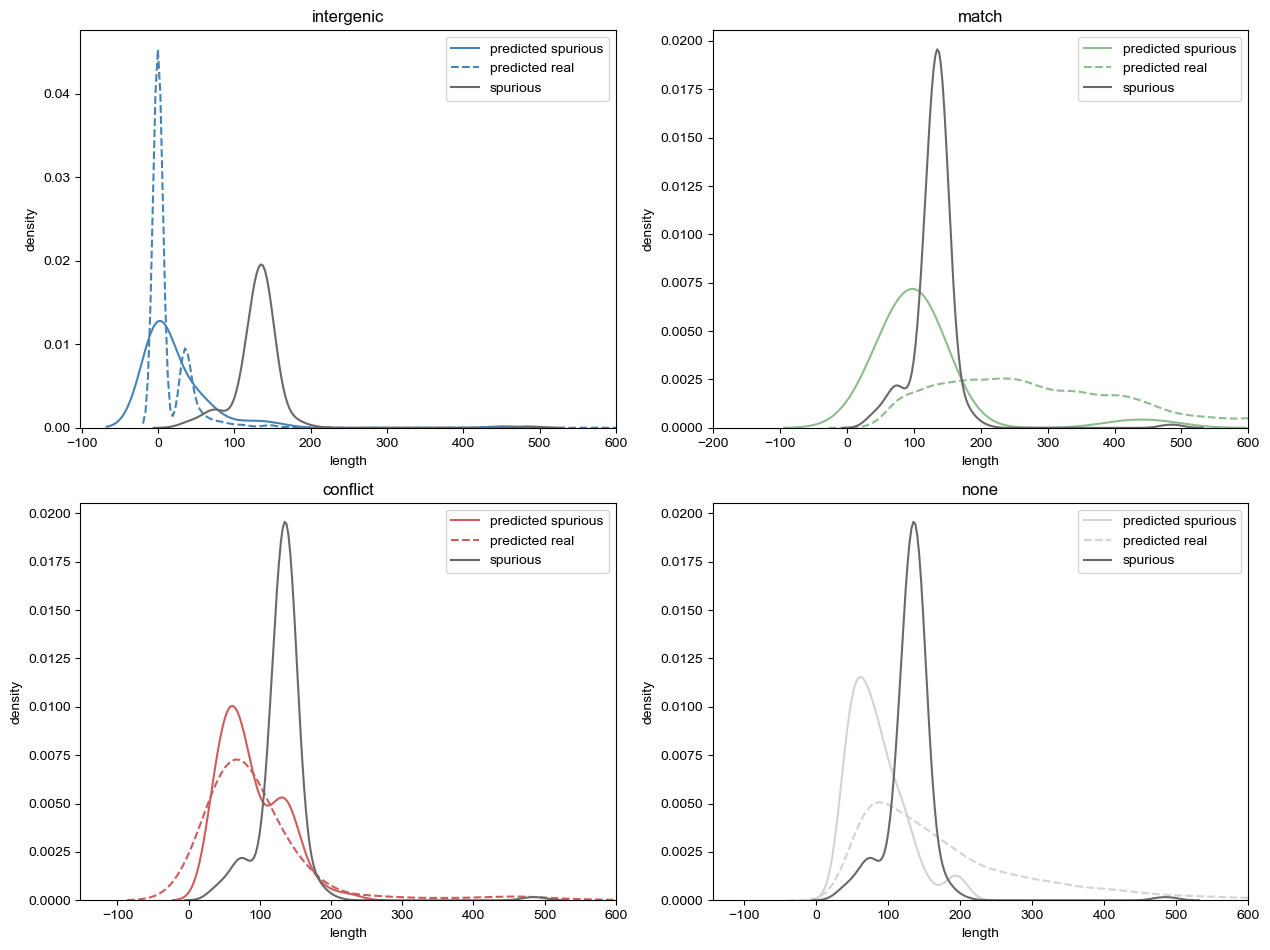

In [ ]:
def figure_4(results, max_length:int=2000, threshold:float=None, path:str='../data/figures/results-campylobacterota-v201-figure_4.png'):
    df = results.to_df()
    if threshold is not None:
        df = df[(df.model_label == 1) | (df.model_output_0 > threshold) | is_spurious(df)]

    fig = plt.figure(layout='tight', figsize=(2 * 6.4, 2 * 4.8))
    grid = GridSpec(figure=fig, nrows=2, ncols=2)
    # axes = [fig.add_subplot(grid[0, i]) for i in range(4)]
    axes = [fig.add_subplot(grid[0, 0]), fig.add_subplot(grid[0, 1]), fig.add_subplot(grid[1, 0]), fig.add_subplot(grid[1, 1])]

    colors = {'intergenic':'steelblue', 'match':'darkseagreen', 'conflict':'indianred', 'none':'lightgray', 'spurious':'dimgray'}
    categories = ['intergenic', 'match', 'conflict', 'none', 'spurious']
    masks = [is_intergenic(df), is_match(df), is_conflict(df), is_none(df), is_spurious(df)]
    
    ax_df = df.copy()
    ax_df['category'] = np.select(masks, categories, default='none')
    ax_df = ax_df[['category', 'query_length', 'model_label']]
    ax_df = ax_df.rename(columns={'query_length':'length'})
    ax_df['length'] = ax_df.length // 3
    ax_df = ax_df[ax_df.length < max_length].copy()

    for ax, category in zip(axes, ['intergenic', 'match', 'conflict', 'none']):
        sns.kdeplot(data=ax_df[(ax_df.category == category) & (ax_df.model_label == 0)], x='length', ax=ax, linewidth=1.5, color=colors[category], label='predicted spurious')
        sns.kdeplot(data=ax_df[(ax_df.category == category) & (ax_df.model_label == 1)], x='length', ax=ax, linewidth=1.5, linestyle='--', color=colors[category], label='predicted real')
        sns.kdeplot(data=ax_df[(ax_df.category == 'spurious')], x='length', ax=ax, linewidth=1.5, color=colors['spurious'], label='spurious')
        ax.set_title(category)
        ax.set_ylabel('density')
        ax.legend()
        ax.set_xlim(xmax=600)

    fig.savefig(path, format='png', dpi=500)
    plt.show()

# figure_4(results, threshold=0.95)
figure_4(results, threshold=None)

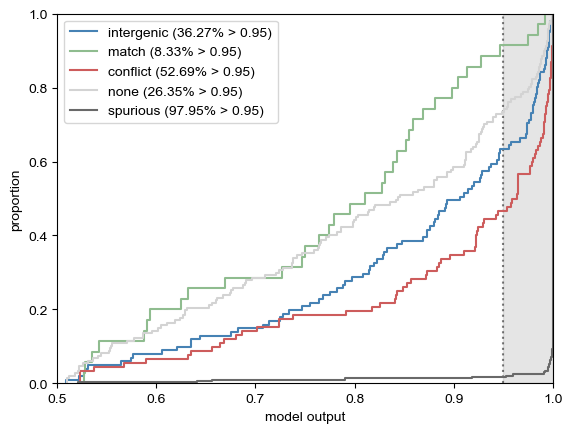

In [ ]:
def figure_4(df:pd.DataFrame, threshold:float=0.95, model_label:int=0):

    df = df[df.model_label == model_label]
    
    fig = plt.figure()
    ax = fig.add_subplot(xlim=(0.5, 1))

    categories = ['intergenic', 'match', 'conflict', 'none', 'spurious']
    colors = ['steelblue', 'darkseagreen', 'indianred', 'lightgray', 'dimgray']
    masks = [is_intergenic(df), is_match(df), is_conflict(df), is_none(df), is_spurious(df)]
    ax_df = df[[f'model_output_{model_label}']].copy()
    ax_df['length'] = df.query_length // 3
    ax_df['category'] = np.select(masks, categories, default=None)

    # sns.stripplot(data=ax_df, jitter=True, x='category', y='model_output_0', hue='category', palette=colors, hue_order=categories)
    for category, color in zip(categories, colors): # Plot each independently so the lines have labels. 
        sns.ecdfplot(data=ax_df[ax_df.category == category], x=f'model_output_{model_label}', color=color, label=category, ax=ax)
    
    legend_labels = []
    for line in ax.lines:
        x, _ = line.get_xydata().T
        p = ((x > threshold).sum() / len(x)) * 100
        p = f'({p:.2f}% > {threshold})'
        n = f'({(x > threshold).sum()} > {threshold})'
        legend_labels.append(f'{line.get_label()} {p}')

    ax.legend(labels=legend_labels)
    ax.set_ylabel('proportion')
    ax.set_xlabel('model output')
    ax.vlines([threshold], ymin=0, ymax=1, linestyle=':', color='black', zorder=-1, alpha=0.5)
    ax.fill_between((threshold, 1), 1, color='black', alpha=0.1, zorder=-1)

    plt.show()

    return ax 

ax = figure_4(results.to_df())

In [ ]:
# Based on model predictions on the complete Campylobacterota dataset, plan to construct a new dataset.

# Seems like trying to automate this process is nearly impossible, as there is an exception for just about every threshold I would try to set. 
# Going to rely on manual evaluation from spreadsheet. Also making the decision to ignore things in the "none" category, as trying to make judgement
# calls for many of these comes down to pitting ab initio tools against one another, or making some assumption about their accuracies. 

conflict_exclude = ['NC_014762.1_1602', 'NZ_AP023212.1_984', 'NZ_JAIGYQ010000001.1_79']
intergenic_exclude = ['NC_014810.2_1592', 'NZ_CDMK01000003.1_14', 'NZ_CP035534.1_1523', 'NZ_CP087125.1_313', 'NZ_FZLB01000053.1_1', 'NZ_JAMOKX010000003.1_63', 'NZ_JAUPEV010000003.1_140', 'NZ_JBHRZO010000012.1_12', 'NZ_JHWC01000001.1_35', 'NZ_KI912401.1_515']
match_include = ['NZ_JAJTMY010000001.1_286']

spurious_ids = list(results.to_df(label='spurious').index)
print(len(spurious_ids), 'spurious entries already labeled by AntiFam.')
spurious_ids += [id_ for id_ in results.to_df(category='conflict', model_label=0).index if (id_ not in conflict_exclude)]
spurious_ids += [id_ for id_ in results.to_df(category='intergenic', model_label=0).index if (id_ not in intergenic_exclude)] 
spurious_ids += match_include
spurious_ids = np.unique(spurious_ids)
print(len(spurious_ids), 'spurious sequences in the augmented training dataset.')

297 spurious entries already labeled by AntiFam.
478 spurious sequences in the augmented training dataset.


In [ ]:

def build_datasets(genome_ids, max_length:int=2000, spurious_ids:list=None, version:str=None):

train_df, test_df, _ = build_datasets(genome_ids, spurious_ids=spurious_ids, version='v201')
# phylum ='Campylobacterota'
# dtypes = {'top_hit_partial':str, 'query_partial':str, 'top_hit_translation_table':str, 'top_hit_codon_start':str}
# train_df = pd.read_csv(f'../data/{phylum.lower()}_dataset_train.csv', index_col=0, dtype=dtypes)
# test_df = pd.read_csv(f'../data/{phylum.lower()}_dataset_test.csv', index_col=0, dtype=dtypes)


build_datasets: Loading data from 196 genomes.
Removing 383 sequences exceeding the maximum length of 2000
build_datasets: Loaded 357444 sequences, 478 labeled spurious and 356966 labeled real.
MMseqs.load: Removing 300625 non-cluster representatives.
build_datasets: Clustering at 50 percent similarity removed 300625 sequences.
build_datasets: 390 negative instances and 43785 positive instances in the training dataset.
build_datasets: 88 negative instances and 12556 positive instances in the testing dataset.
